# One Step Sketch to Image translation with pix2pix-turbo and OpenVINO

Diffusion models achieve remarkable results in image generation. They are able synthesize high-quality images guided by user instructions. In the same time, majority of diffusion-based image generation approaches are time-consuming due to the iterative denoising process.Pix2Pix-turbo model was proposed in [One-Step Image Translation with Text-to-Image Models paper](https://arxiv.org/abs/2403.12036) for addressing slowness of diffusion process in image-to-image translation task. It is based on [SD-Turbo](https://huggingface.co/stabilityai/sd-turbo), a fast generative text-to-image model that can synthesize photorealistic images from a text prompt in a single network evaluation. Using only single inference, pix2pix-turbo achieves comparable by quality results with recent works such as ControlNet for Sketch2Photo and Edge2Image for 50 steps.

![](https://github.com/GaParmar/img2img-turbo/raw/main/assets/gen_variations.jpg)

In this tutorial you will learn how to turn sketches to images using [Pix2Pix-Turbo](https://github.com/GaParmar/img2img-turbo) and OpenVINO.
#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Load PyTorch model](#Load-PyTorch-model)
- [Convert PyTorch model to Openvino Intermediate Representation format](#Convert-PyTorch-model-to-Openvino-Intermediate-Representation-format)
- [Select inference device](#Select-inference-device)
- [Compile model](#Compile-model)
- [Run model inference](#Run-model-inference)
- [Interactive demo](#Interactive-demo)


### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/sketch-to-image-pix2pix-turbo/sketch-to-image-pix2pix-turbo.ipynb" />


## Prerequisites
[back to top ⬆️](#Table-of-contents:)

Clone [model repository](https://github.com/GaParmar/img2img-turbo) and install required packages.

In [ ]:
%pip install -q "openvino>=2024.1.0" "torch>=2.1" torchvision "diffusers==0.25.1" "peft>=0.6.2" transformers tqdm pillow opencv-python "gradio==3.43.1" --extra-index-url https://download.pytorch.org/whl/cpu

In [ ]:
from pathlib import Path

repo_dir = Path("img2img-turbo")

if not repo_dir.exists():
    !git clone https://github.com/GaParmar/img2img-turbo.git

pix2pix_turbo_py_path = repo_dir / "src/pix2pix_turbo.py"
model_py_path = repo_dir / "src/model.py"
orig_pix2pix_turbo_path = pix2pix_turbo_py_path.parent / ("orig_" + pix2pix_turbo_py_path.name)
orig_model_py_path = model_py_path.parent / ("orig_" + model_py_path.name)

if not orig_pix2pix_turbo_path.exists():
    pix2pix_turbo_py_path.rename(orig_pix2pix_turbo_path)

    with orig_pix2pix_turbo_path.open("r") as f:
        data = f.read()
        data = data.replace("cuda", "cpu")
        with pix2pix_turbo_py_path.open("w") as out_f:
            out_f.write(data)

if not orig_model_py_path.exists():
    model_py_path.rename(orig_model_py_path)

    with orig_model_py_path.open("r") as f:
        data = f.read()
        data = data.replace("cuda", "cpu")
        with model_py_path.open("w") as out_f:
            out_f.write(data)
%cd $repo_dir

## Load PyTorch model
[back to top ⬆️](#Table-of-contents:)

Pix2Pix-turbo architecture illustrated on the diagram below. Model combines three separate modules in the original latent diffusion models into a single end-to-end network with small trainable weights. This architecture allows translation the input image x to the output y, while retaining the input scene structure. Authors use LoRA adapters in each module, introduce skip connections and Zero-Convolutions between input and output, and retrain the first layer of the U-Net. Blue boxes on diagram indicate trainable layers. Semi-transparent layers are frozen. 
![model_diagram](https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/18f1a442-8547-4edd-85b0-d8bd1a99bdf1)

In [ ]:
import requests
import copy
from tqdm import tqdm
import torch
from transformers import AutoTokenizer, CLIPTextModel
from diffusers import AutoencoderKL, UNet2DConditionModel
from diffusers.models.autoencoders.vae import DiagonalGaussianDistribution
from diffusers.utils.peft_utils import set_weights_and_activate_adapters
from peft import LoraConfig
import types

from src.model import make_1step_sched
from src.pix2pix_turbo import TwinConv

tokenizer = AutoTokenizer.from_pretrained("stabilityai/sd-turbo", subfolder="tokenizer")


def tokenize_prompt(prompt):
    caption_tokens = tokenizer(prompt, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids
    return caption_tokens


def _vae_encoder_fwd(self, sample):
    sample = self.conv_in(sample)
    l_blocks = []
    # down
    for down_block in self.down_blocks:
        l_blocks.append(sample)
        sample = down_block(sample)
    # middle
    sample = self.mid_block(sample)
    sample = self.conv_norm_out(sample)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)
    current_down_blocks = l_blocks
    return sample, current_down_blocks


def _vae_decoder_fwd(self, sample, incoming_skip_acts, latent_embeds=None):
    sample = self.conv_in(sample)
    upscale_dtype = next(iter(self.up_blocks.parameters())).dtype
    # middle
    sample = self.mid_block(sample, latent_embeds)
    sample = sample.to(upscale_dtype)
    if not self.ignore_skip:
        skip_convs = [self.skip_conv_1, self.skip_conv_2, self.skip_conv_3, self.skip_conv_4]
        # up
        for idx, up_block in enumerate(self.up_blocks):
            skip_in = skip_convs[idx](incoming_skip_acts[::-1][idx] * self.gamma)
            # add skip
            sample = sample + skip_in
            sample = up_block(sample, latent_embeds)
    else:
        for idx, up_block in enumerate(self.up_blocks):
            sample = up_block(sample, latent_embeds)
    # post-process
    if latent_embeds is None:
        sample = self.conv_norm_out(sample)
    else:
        sample = self.conv_norm_out(sample, latent_embeds)
    sample = self.conv_act(sample)
    sample = self.conv_out(sample)
    return sample


def vae_encode(self, x: torch.FloatTensor):
    """
    Encode a batch of images into latents.

    Args:
        x (`torch.FloatTensor`): Input batch of images.

    Returns:
        The latent representations of the encoded images. If `return_dict` is True, a
        [`~models.autoencoder_kl.AutoencoderKLOutput`] is returned, otherwise a plain `tuple` is returned.
    """
    h, down_blocks = self.encoder(x)

    moments = self.quant_conv(h)
    posterior = DiagonalGaussianDistribution(moments)

    return (posterior, down_blocks)


def vae_decode(self, z: torch.FloatTensor, skip_acts):
    decoded = self._decode(z, skip_acts)[0]
    return (decoded,)


def vae__decode(self, z: torch.FloatTensor, skip_acts):
    z = self.post_quant_conv(z)
    dec = self.decoder(z, skip_acts)

    return (dec,)


class Pix2PixTurbo(torch.nn.Module):
    def __init__(self, pretrained_name=None, pretrained_path=None, ckpt_folder="checkpoints", lora_rank_unet=8, lora_rank_vae=4):
        super().__init__()
        self.text_encoder = CLIPTextModel.from_pretrained("stabilityai/sd-turbo", subfolder="text_encoder", variant="fp16").cpu()
        self.sched = make_1step_sched()

        vae = AutoencoderKL.from_pretrained("stabilityai/sd-turbo", subfolder="vae", variant="fp16")
        vae.encoder.forward = types.MethodType(_vae_encoder_fwd, vae.encoder)
        vae.decoder.forward = types.MethodType(_vae_decoder_fwd, vae.decoder)
        vae.encode = types.MethodType(vae_encode, vae)
        vae.decode = types.MethodType(vae_decode, vae)
        vae._decode = types.MethodType(vae__decode, vae)
        # add the skip connection convs
        vae.decoder.skip_conv_1 = torch.nn.Conv2d(512, 512, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.skip_conv_2 = torch.nn.Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.skip_conv_3 = torch.nn.Conv2d(128, 512, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.skip_conv_4 = torch.nn.Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False).cpu()
        vae.decoder.ignore_skip = False
        unet = UNet2DConditionModel.from_pretrained("stabilityai/sd-turbo", subfolder="unet", variant="fp16")
        ckpt_folder = Path(ckpt_folder)

        if pretrained_name == "edge_to_image":
            url = "https://www.cs.cmu.edu/~img2img-turbo/models/edge_to_image_loras.pkl"
            ckpt_folder.mkdir(exist_ok=True)
            outf = ckpt_folder / "edge_to_image_loras.pkl"
            if not outf:
                print(f"Downloading checkpoint to {outf}")
                response = requests.get(url, stream=True)
                total_size_in_bytes = int(response.headers.get("content-length", 0))
                block_size = 1024  # 1 Kibibyte
                progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
                with open(outf, "wb") as file:
                    for data in response.iter_content(block_size):
                        progress_bar.update(len(data))
                        file.write(data)
                progress_bar.close()
                if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                    print("ERROR, something went wrong")
                print(f"Downloaded successfully to {outf}")
            p_ckpt = outf
            sd = torch.load(p_ckpt, map_location="cpu")
            unet_lora_config = LoraConfig(r=sd["rank_unet"], init_lora_weights="gaussian", target_modules=sd["unet_lora_target_modules"])
            vae_lora_config = LoraConfig(r=sd["rank_vae"], init_lora_weights="gaussian", target_modules=sd["vae_lora_target_modules"])
            vae.add_adapter(vae_lora_config, adapter_name="vae_skip")
            _sd_vae = vae.state_dict()
            for k in sd["state_dict_vae"]:
                _sd_vae[k] = sd["state_dict_vae"][k]
            vae.load_state_dict(_sd_vae)
            unet.add_adapter(unet_lora_config)
            _sd_unet = unet.state_dict()
            for k in sd["state_dict_unet"]:
                _sd_unet[k] = sd["state_dict_unet"][k]
            unet.load_state_dict(_sd_unet)

        elif pretrained_name == "sketch_to_image_stochastic":
            # download from url
            url = "https://www.cs.cmu.edu/~img2img-turbo/models/sketch_to_image_stochastic_lora.pkl"
            ckpt_folder.mkdir(exist_ok=True)
            outf = ckpt_folder / "sketch_to_image_stochastic_lora.pkl"
            if not outf.exists():
                print(f"Downloading checkpoint to {outf}")
                response = requests.get(url, stream=True)
                total_size_in_bytes = int(response.headers.get("content-length", 0))
                block_size = 1024  # 1 Kibibyte
                progress_bar = tqdm(total=total_size_in_bytes, unit="iB", unit_scale=True)
                with open(outf, "wb") as file:
                    for data in response.iter_content(block_size):
                        progress_bar.update(len(data))
                        file.write(data)
                progress_bar.close()
                if total_size_in_bytes != 0 and progress_bar.n != total_size_in_bytes:
                    print("ERROR, something went wrong")
                print(f"Downloaded successfully to {outf}")
            p_ckpt = outf
            convin_pretrained = copy.deepcopy(unet.conv_in)
            unet.conv_in = TwinConv(convin_pretrained, unet.conv_in)
            sd = torch.load(p_ckpt, map_location="cpu")
            unet_lora_config = LoraConfig(r=sd["rank_unet"], init_lora_weights="gaussian", target_modules=sd["unet_lora_target_modules"])
            vae_lora_config = LoraConfig(r=sd["rank_vae"], init_lora_weights="gaussian", target_modules=sd["vae_lora_target_modules"])
            vae.add_adapter(vae_lora_config, adapter_name="vae_skip")
            _sd_vae = vae.state_dict()
            for k in sd["state_dict_vae"]:
                if k not in _sd_vae:
                    continue
                _sd_vae[k] = sd["state_dict_vae"][k]

            vae.load_state_dict(_sd_vae)
            unet.add_adapter(unet_lora_config)
            _sd_unet = unet.state_dict()
            for k in sd["state_dict_unet"]:
                _sd_unet[k] = sd["state_dict_unet"][k]
            unet.load_state_dict(_sd_unet)

        elif pretrained_path is not None:
            sd = torch.load(pretrained_path, map_location="cpu")
            unet_lora_config = LoraConfig(r=sd["rank_unet"], init_lora_weights="gaussian", target_modules=sd["unet_lora_target_modules"])
            vae_lora_config = LoraConfig(r=sd["rank_vae"], init_lora_weights="gaussian", target_modules=sd["vae_lora_target_modules"])
            vae.add_adapter(vae_lora_config, adapter_name="vae_skip")
            _sd_vae = vae.state_dict()
            for k in sd["state_dict_vae"]:
                _sd_vae[k] = sd["state_dict_vae"][k]
            vae.load_state_dict(_sd_vae)
            unet.add_adapter(unet_lora_config)
            _sd_unet = unet.state_dict()
            for k in sd["state_dict_unet"]:
                _sd_unet[k] = sd["state_dict_unet"][k]
            unet.load_state_dict(_sd_unet)

        # unet.enable_xformers_memory_efficient_attention()
        unet.to("cpu")
        vae.to("cpu")
        self.unet, self.vae = unet, vae
        self.vae.decoder.gamma = 1
        self.timesteps = torch.tensor([999], device="cpu").long()
        self.text_encoder.requires_grad_(False)

    def set_r(self, r):
        self.unet.set_adapters(["default"], weights=[r])
        set_weights_and_activate_adapters(self.vae, ["vae_skip"], [r])
        self.r = r
        self.unet.conv_in.r = r
        self.vae.decoder.gamma = r

    def forward(self, c_t, prompt_tokens, noise_map):
        caption_enc = self.text_encoder(prompt_tokens)[0]
        # scale the lora weights based on the r value
        sample, current_down_blocks = self.vae.encode(c_t)
        encoded_control = sample.sample() * self.vae.config.scaling_factor
        # combine the input and noise
        unet_input = encoded_control * self.r + noise_map * (1 - self.r)

        unet_output = self.unet(
            unet_input,
            self.timesteps,
            encoder_hidden_states=caption_enc,
        ).sample
        x_denoised = self.sched.step(unet_output, self.timesteps, unet_input, return_dict=True).prev_sample
        output_image = (self.vae.decode(x_denoised / self.vae.config.scaling_factor, current_down_blocks)[0]).clamp(-1, 1)
        return output_image

In [4]:
ov_model_path = Path("model/pix2pix-turbo.xml")

pt_model = None

if not ov_model_path.exists():
    pt_model = Pix2PixTurbo("sketch_to_image_stochastic")
    pt_model.set_r(0.4)
    pt_model.eval()

model.fp16.safetensors:   0%|          | 0.00/681M [00:00<?, ?B/s]

/home/ea/work/my_optimum_intel/optimum_env/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

## Convert PyTorch model to Openvino Intermediate Representation format
[back to top ⬆️](#Table-of-contents:)

Starting from OpenVINO 2023.0 release, OpenVINO supports direct PyTorch models conversion to [OpenVINO Intermediate Representation (IR) format](https://docs.openvino.ai/2024/documentation/openvino-ir-format.html) to take the advantage of advanced OpenVINO optimization tools and features. You need to provide a model object, input data for model tracing to [OpenVINO Model Conversion API](https://docs.openvino.ai/2024/openvino-workflow/model-preparation/convert-model-to-ir.html). `ov.convert_model` function convert PyTorch model instance to `ov.Model` object that can be used for compilation on device or saved on disk using `ov.save_model` in compressed to FP16 format.

In [ ]:
import gc
import openvino as ov

if not ov_model_path.exists():
    example_input = [torch.ones((1, 3, 512, 512)), torch.ones([1, 77], dtype=torch.int64), torch.ones([1, 4, 64, 64])]
    with torch.no_grad():
        ov_model = ov.convert_model(pt_model, example_input=example_input, input=[[1, 3, 512, 512], [1, 77], [1, 4, 64, 64]])
        ov.save_model(ov_model, ov_model_path)
    del ov_model
    torch._C._jit_clear_class_registry()
    torch.jit._recursive.concrete_type_store = torch.jit._recursive.ConcreteTypeStore()
    torch.jit._state._clear_class_state()
del pt_model
gc.collect();

# uncomment these lines if you want cleenup download pytorch model checkpoints

# import shutil

# checkpoints_dir = Path("checkpoints")
# for file in checkpoints_dir.glob("*"):
#     shutil.rmtree(file, ignore_errors=True)

## Select inference device
[back to top ⬆️](#Table-of-contents:)

In [6]:
r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)
open("notebook_utils.py", "w").write(r.text)

from notebook_utils import device_widget

device = device_widget()

device

Dropdown(description='Device:', index=3, options=('CPU', 'GPU.0', 'GPU.1', 'AUTO'), value='AUTO')

## Compile model
[back to top ⬆️](#Table-of-contents:)

In [7]:
import openvino as ov

core = ov.Core()
compiled_model = core.compile_model(ov_model_path, device.value)

## Run model inference
[back to top ⬆️](#Table-of-contents:)

Now, let's try model in action and turn simple cat sketch into professional artwork.

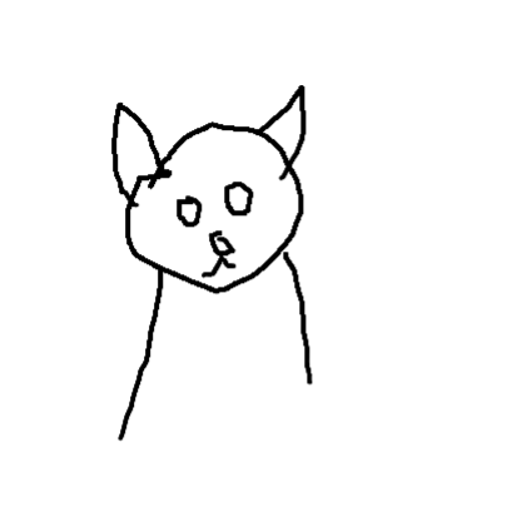

In [8]:
from diffusers.utils import load_image

sketch_image = load_image("https://github.com/openvinotoolkit/openvino_notebooks/assets/29454499/f964a51d-34e8-411a-98f4-5f97a28f56b0")

sketch_image

In [9]:
import torchvision.transforms.functional as F

torch.manual_seed(145)
c_t = torch.unsqueeze(F.to_tensor(sketch_image) > 0.5, 0)
noise = torch.randn((1, 4, 512 // 8, 512 // 8))

In [10]:
prompt_template = "anime artwork {prompt} . anime style, key visual, vibrant, studio anime,  highly detailed"
prompt = prompt_template.replace("{prompt}", "fluffy  magic cat")

prompt_tokens = tokenize_prompt(prompt)

In [11]:
result = compiled_model([1 - c_t.to(torch.float32), prompt_tokens, noise])[0]

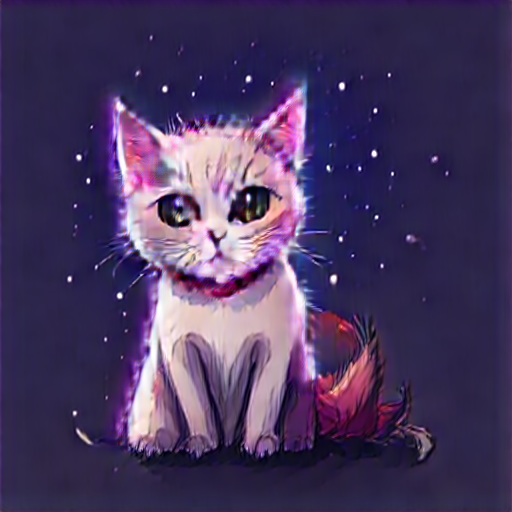

In [12]:
from PIL import Image
import numpy as np

image_tensor = (result[0] * 0.5 + 0.5) * 255
image = np.transpose(image_tensor, (1, 2, 0)).astype(np.uint8)
Image.fromarray(image)

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In this section, you can try model on own paintings.

**Instructions:**
* Enter a text prompt (e.g. cat)
* Start sketching, using pencil and eraser buttons
* Change the image style using a style template
* Try different seeds to generate different results
* Download results using download button

In [ ]:
import base64
from io import BytesIO
import gradio as gr


def pil_image_to_data_uri(img, format="PNG"):
    buffered = BytesIO()
    img.save(buffered, format=format)
    img_str = base64.b64encode(buffered.getvalue()).decode()
    return f"data:image/{format.lower()};base64,{img_str}"


def run(image, prompt, prompt_template, style_name, seed):
    print(f"prompt: {prompt}")
    print("sketch updated")
    if image is None:
        ones = Image.new("L", (512, 512), 255)
        temp_uri = pil_image_to_data_uri(ones)
        return ones, gr.update(link=temp_uri), gr.update(link=temp_uri)
    prompt = prompt_template.replace("{prompt}", prompt)
    image = image.convert("RGB")
    image_t = F.to_tensor(image) > 0.5
    print(f"seed={seed}")
    caption_tokens = tokenizer(prompt, max_length=tokenizer.model_max_length, padding="max_length", truncation=True, return_tensors="pt").input_ids.cpu()
    with torch.no_grad():
        c_t = image_t.unsqueeze(0)
        torch.manual_seed(seed)
        B, C, H, W = c_t.shape
        noise = torch.randn((1, 4, H // 8, W // 8))
        output_image = torch.from_numpy(compiled_model([c_t.to(torch.float32), caption_tokens, noise])[0])
    output_pil = F.to_pil_image(output_image[0].cpu() * 0.5 + 0.5)
    input_sketch_uri = pil_image_to_data_uri(Image.fromarray(255 - np.array(image)))
    output_image_uri = pil_image_to_data_uri(output_pil)
    return (
        output_pil,
        gr.update(link=input_sketch_uri),
        gr.update(link=output_image_uri),
    )

In [ ]:
# Go back to the sketch-to-image-pix2pix-turbo notebook directory
%cd ..

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/sketch-to-image-pix2pix-turbo/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

from gradio_helper import make_demo

demo = make_demo(fn=run)

try:
    demo.queue().launch(debug=True)
except Exception:
    demo.queue().launch(debug=True, share=True)
# If you are launching remotely, specify server_name and server_port
# EXAMPLE: `demo.launch(server_name='your server name', server_port='server port in int')`
# To learn more please refer to the Gradio docs: https://gradio.app/docs/

In [ ]:
# please uncomment and run this cell for stopping gradio interface
# demo.close()